In [1]:
import sys, os
import sparse
import xsimlab as xs
import xarray as xr
import numpy as np
import pandas as pd
import igraph as ig
from pgljupyter import SceneWidget

In [2]:
sys.path.insert(0, os.path.join(os.getcwd(), '..'))
import vmlab
from vmlab.models.vmango import vmango as model
from vmlab.enums import Nature

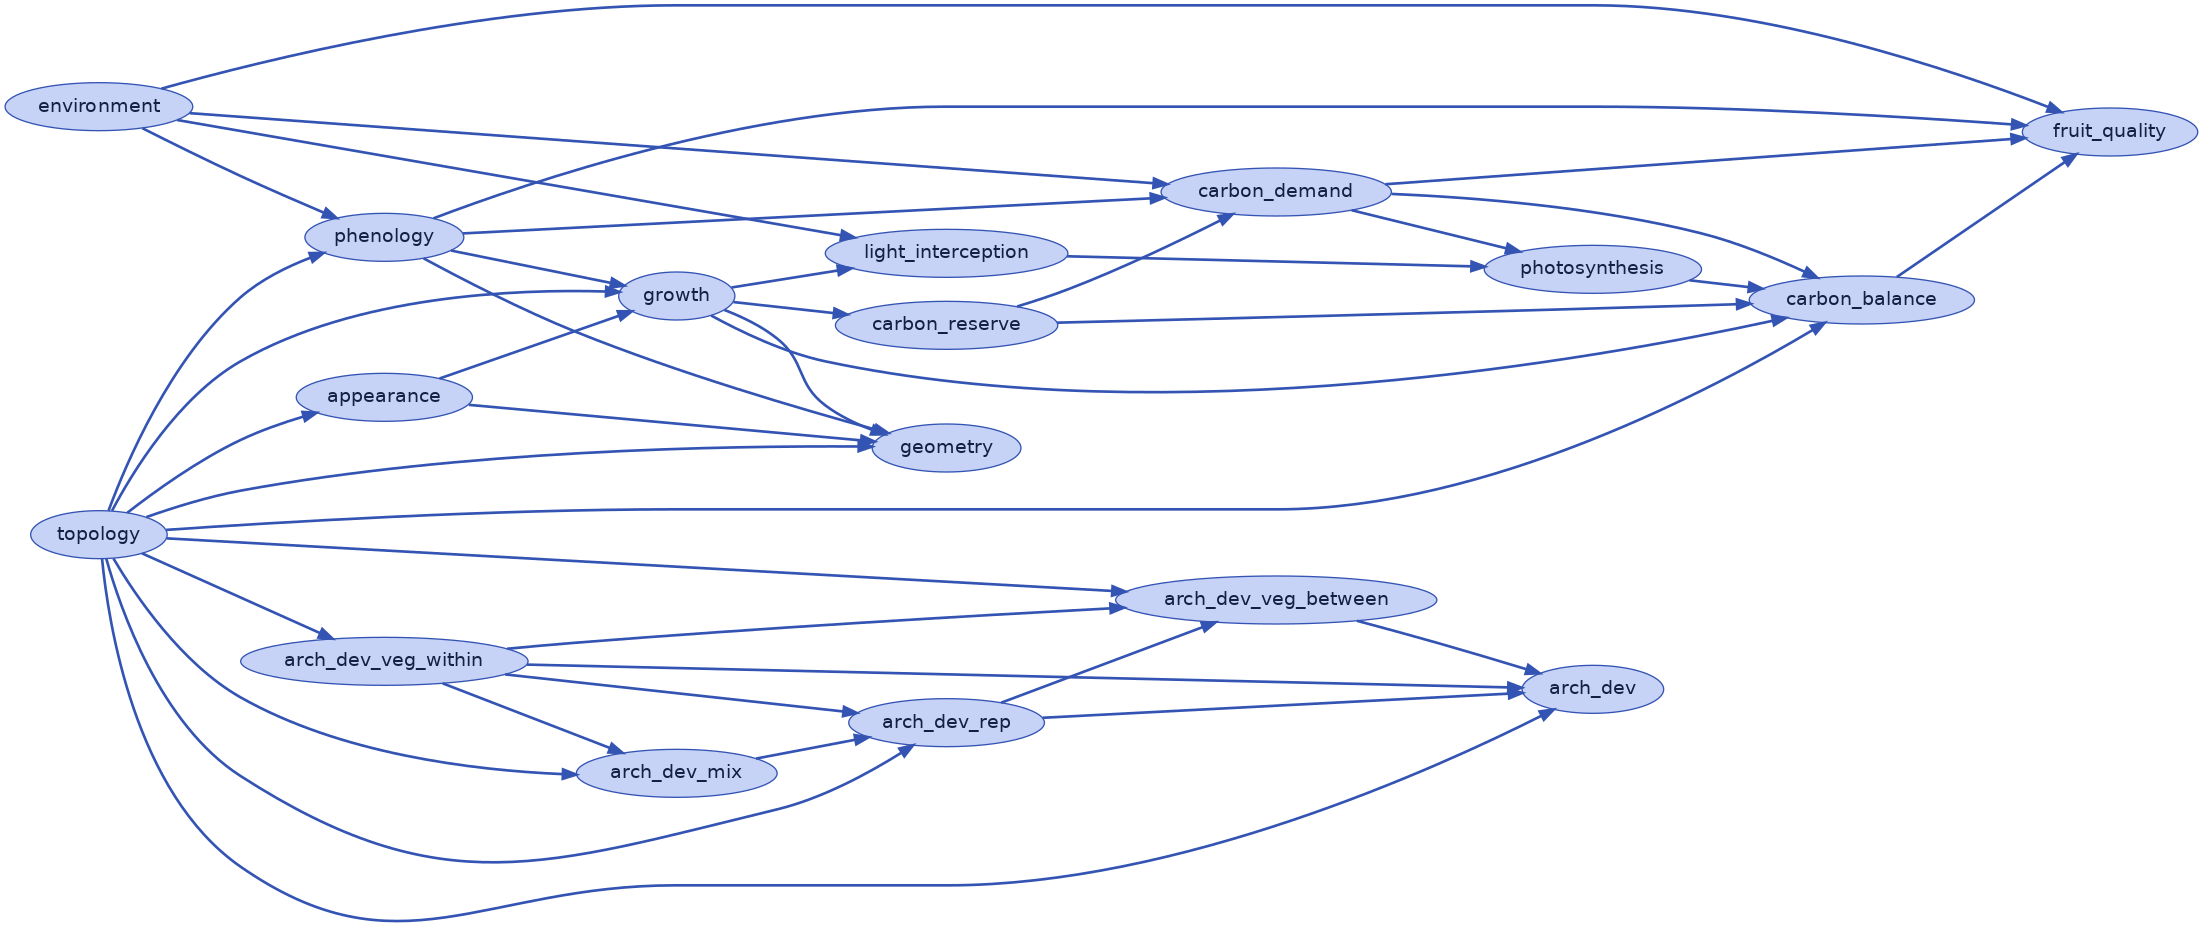

In [3]:
model.visualize()

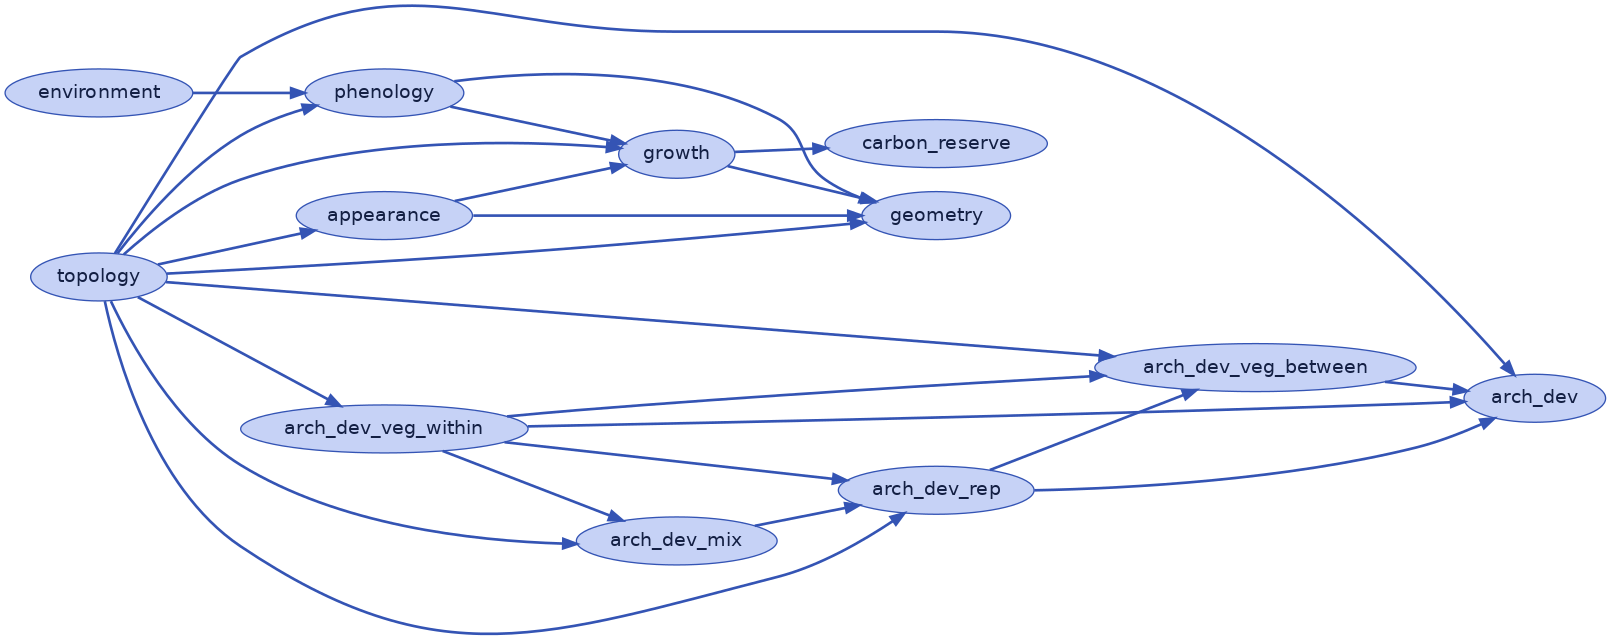

In [4]:
model = model.drop_processes(['light_interception', 'photosynthesis', 'carbon_reserves', 'carbon_demand', 'carbon_balance', 'fruit_quality'])
# model = model.drop_processes(['geometry'])
model.visualize()

In [5]:
ds = vmlab.create_setup(
    model,
    start_date='2002-04-01',
    end_date='2005-06-30',
    setup_toml='../share/setup/vmango.toml',
    current_cycle=3,
    input_vars={
        'topology': {
            'seed': 0,
            'month_begin_veg_cycle': 7,
            'doy_begin_flowering': 214
        },
        'geometry__interpretation_freq': -1
    },
    output_vars=None
)

In [6]:
ds

<xarray.Dataset>
Dimensions:                                    (GU: 239, day: 1187)
Coordinates:
  * day                                        (day) datetime64[ns] 2002-04-0...
Dimensions without coordinates: GU
Data variables: (12/31)
    topology__nb_gu                            int64 0
    topology__seed                             int64 0
    topology__month_begin_veg_cycle            int64 7
    topology__doy_begin_flowering              int64 214
    geometry__interpretation_freq              int64 -1
    environment__parameter_file_path           <U52 '../share/setup/../parame...
    ...                                         ...
    arch_dev__pot_flowering_date               (GU) float32 -4.948e-27 ... 12.0
    arch_dev__pot_nature                       (GU) float32 -4.948e-27 ... -5...
    arch_dev__pot_has_apical_child             (GU) float32 -4.947e-27 ... -4...
    arch_dev__pot_nb_lateral_children          (GU) float32 -4.948e-27 ... -5...
    arch_dev__pot_nb_inflo                     (GU) float32 -4.947e-27 ... -4...
    arch_dev__pot_nb_fruit                     (GU) float32 -4.947e-27 ... -5...
Attributes:
    __xsimlab_output_vars__:  environment__parameter_file_path,environment__T...

In [7]:
sw = SceneWidget(size_world=2.5)
sw

SceneWidget(scenes=[{'id': 'rhzC5cfIjKZjgpCYY4iUX3lCl', 'data': b'x\xdaSLrw\xf5\xf7e`Pp\xe0\xe5RPVVd\x00\x020\…

In [8]:
scene_ = None
@xs.runtime_hook(stage='run_step')
def hook(model, context, state):
    global scene_
    scene = state[('geometry', 'scene')]
    if scene != scene_:
        sw.set_scenes([scene], scales=[1/100])
        scene_ = scene
    
ds_out = ds.xsimlab.run(model=model, decoding={ 'mask_and_scale': False }, hooks=[xs.monitoring.ProgressBar(), hook])
ds_out

             0% | initialize 

<xarray.Dataset>
Dimensions:                                             (GU: 2106, day: 1187, hour: 24)
Coordinates:
  * GU                                                  (GU) <U10 'GU0' ... '...
  * day                                                 (day) datetime64[ns] ...
  * hour                                                (hour) int8 0 1 ... 23
Data variables: (12/100)
    appearance__appeared                                (GU) float32 1.0 ... 1.0
    appearance__final_length_gu                         (GU) float32 13.26 .....
    appearance__final_length_inflos                     (GU) object None ... ...
    appearance__final_length_internodes                 (GU) object [5.816673...
    appearance__final_length_leaves                     (GU) object [17.01209...
    appearance__nb_internode                            (GU) float32 13.0 ......
    ...                                                  ...
    topology__nb_fruit                                  (GU) float32 0.0 ... 0.0
    topology__nb_gu                                     int64 2106
    topology__nb_inflo                                  (GU) float32 0.0 ... 0.0
    topology__parent_is_apical                          (GU) float32 1.0 ... 1.0
    topology__seed                                      int64 0
    topology__sim_start_date                            datetime64[D] 2002-04-01

<AxesSubplot:xlabel='topology__appearance_date'>

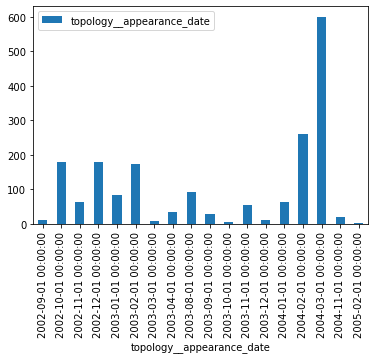

In [9]:
appearance_date = ds_out.topology__appearance_date.groupby(ds_out.topology__appearance_date)
appearance_date.count().to_dataframe().plot.bar()

<AxesSubplot:xlabel='arch_dev__pot_burst_date'>

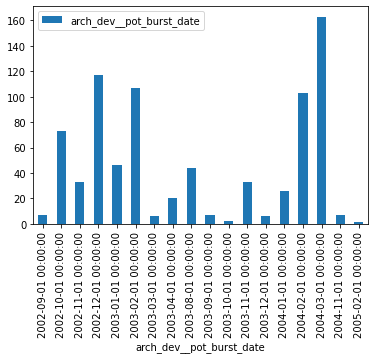

In [10]:
pot_burst_date = ds_out.arch_dev__pot_burst_date.groupby(ds_out.arch_dev__pot_burst_date)
pot_burst_date.count().to_dataframe().plot.bar()

<AxesSubplot:xlabel='arch_dev__pot_flowering_date'>

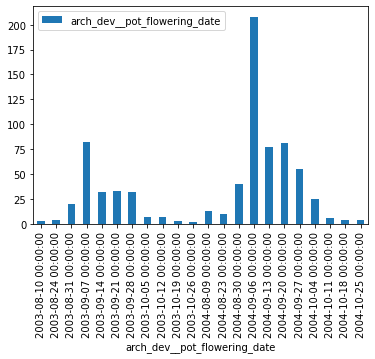

In [11]:
pot_flowering_date = ds_out.arch_dev__pot_flowering_date.groupby(ds_out.arch_dev__pot_flowering_date)
pot_flowering_date.count().to_dataframe().plot.bar()

<AxesSubplot:xlabel='topology__nb_inflo'>

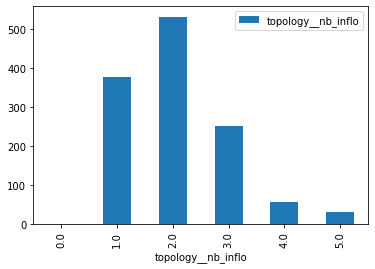

In [12]:
topology__nb_inflo = ds_out.topology__nb_inflo.groupby(ds_out.topology__nb_inflo)
topology__nb_inflo.sum().to_dataframe().plot.bar()

<AxesSubplot:xlabel='topology__nb_fruit'>

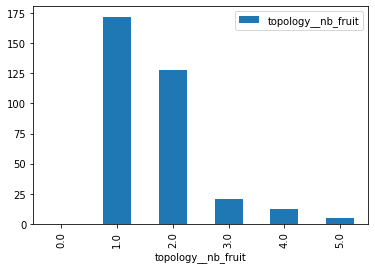

In [13]:
nb_fruit = ds_out.topology__nb_fruit.groupby(ds_out.topology__nb_fruit)
nb_fruit.sum().to_dataframe().plot.bar()

<AxesSubplot:xlabel='nb_children'>

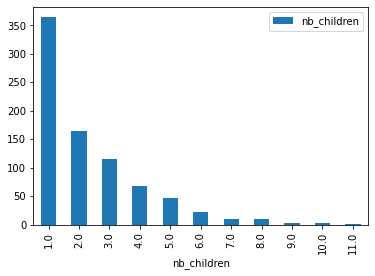

In [14]:
nb_children = xr.DataArray(ds_out.arch_dev__pot_has_apical_child + ds_out.arch_dev__pot_nb_lateral_children, name='nb_children')
nb_children = nb_children[nb_children > 0]
nb_children.groupby(nb_children).count().to_dataframe().plot.bar()

In [15]:
nb_children = xr.DataArray(ds_out.arch_dev__pot_has_apical_child + ds_out.arch_dev__pot_nb_lateral_children, name='nb_children')
ds_children = xr.Dataset({
    'nb_children':  nb_children[nb_children > 0], 
    'cycle': ds_out.topology__cycle[nb_children > 0]
})
ds_children

<xarray.Dataset>
Dimensions:      (GU: 806)
Coordinates:
  * GU           (GU) <U10 'GU4' 'GU7' 'GU9' ... 'GU1442' 'GU1467' 'GU1471'
Data variables:
    nb_children  (GU) float32 2.0 5.0 5.0 2.0 2.0 3.0 ... 4.0 1.0 5.0 1.0 3.0
    cycle        (GU) float32 3.0 3.0 3.0 3.0 3.0 3.0 ... 5.0 5.0 5.0 5.0 5.0

<AxesSubplot:xlabel='cycle'>

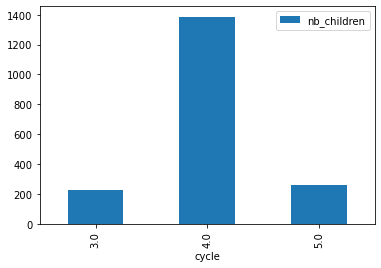

In [16]:
ds_children.groupby(ds_children.cycle).sum().to_dataframe().plot.bar()